### Анализ сервиса аренды самокатов GoFast
Цель исследования: Проанализировать данные и проверить некоторые гипотезы, которые могут помочь сервису аренды самокатов GoFast вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
без подписки и с подпиской Ultra

Услуга|Без подписки  | с подпиской Ultra
------------- | -------------| -------------
абонентская плата  | отсутствует | 199 рублей в месяц
стоимость одной минуты поездки  | 8 рублей|6 рублей
стоимость старта   | 50 рублей|бесплатно

Описание данных

В основных данных есть информация о пользователях, их поездках и подписках.

Пользователи — [users_go.csv](https://code.s3.yandex.net/datasets/users_go.csv)

- `user_id` -  уникальный идентификатор пользователя
- `name` - имя пользователя
- `age` - возраст
- `city` - город
- `subscription_type` - тип подписки (free, ultra)


Поездки — [rides_go.csv](https://code.s3.yandex.net/datasets/rides_go.csv)

- `user_id` - уникальный идентификатор пользователя
- `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` - продолжительность сессии (в минутах)
- `date` - дата совершения поездки

Подписки — [subscriptions_go.csv](https://code.s3.yandex.net/datasets/subscriptions_go.csv)

- `subscription_type` - тип подписки
- `minute_price` - стоимость одной минуты поездки по данной подписке
- `start_ride_price` - стоимость начала поездки
- `subscription_fee` - стоимость ежемесячного платежа


План работы

1. Шаг 1. Загрузка данных
    1. Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраним их в датафреймы. Пути к файлам:
    2. Выведем первые строки каждого набора данных. Изучим общую информацию о каждом датафрейме.
2. Шаг 2. Предобработка данных
    1. Приведем столбец date к типу даты pandas.
    2. Создадим новый столбец с номером месяца на основе столбца date.
    3. Проверим наличие пропущенных значений и дубликатов в датафреймах. Обработаем их, если такие значения присутствуют.
3. Шаг 3. Исследовательский анализ данных Опишем и визуализируем общую информацию о пользователях и поездках:
    1. Частота встречаемости городов;
    2. Соотношение пользователей с подпиской и без подписки;
    3. Возраст пользователей;
    4. Расстояние, которое пользователь преодолел за одну поездку;
    5. Продолжительность поездок.
4. Шаг 4. Объединение данных
    1. Объединим данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуемся методом merge().
    2. Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1:
        - c данными о пользователях без подписки;
        - с данными о пользователях с подпиской.
    3. Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.
5. Шаг 5. Подсчёт выручки
    1. Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
    2. В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа.
6. Шаг 6. Проверка гипотез. Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.
    1. Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.
    2. 6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим гипотезу и сделаем выводы.
    3. Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделаем вывод.
    4. Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест нам понадобился бы для проверки этой гипотезы?

In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных
##### Считываем CSV-файлы с данными с помощью библиотеки pandas и сохраняем их в датафреймы

In [2]:
try:
    us_df=pd.read_csv('/datasets/users_go.csv')
    ri_df=pd.read_csv('/datasets/rides_go.csv')
    su_df=pd.read_csv('/datasets/subscriptions_go.csv')
except:
    us_df=pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    ri_df=pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    su_df=pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

display(us_df.head())
display(us_df.info())
display(ri_df.head())
display(ri_df.info())
display(su_df.head())
display(su_df.info())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

Вывод: Из набора данных us_df видно, что всего есть 1565 пользователей, которые за время наблюдения совершили 18068 поездок (ri_df).В данных su_df указаны данные о параметрах подписки. 

Неверно указан тип данных ri_df в столбце date.

#### Шаг 2. Предобработка данных
##### Приведем столбец date к типу даты pandas.

In [3]:
ri_df['date']=pd.to_datetime(ri_df['date'])
ri_df.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


##### Создаем новый столбец с номером месяца на основе столбца date.

In [4]:
ri_df['date_month']=ri_df.date.astype('datetime64[M]')
ri_df.head()


,user_id,distance,duration,date,date_month
0,1,4409.919140,25.599769,2021-01-01,2021-01-01
1,1,2617.592153,15.816871,2021-01-18,2021-01-01
2,1,754.159807,6.232113,2021-04-20,2021-04-01
3,1,2694.783254,18.511000,2021-08-11,2021-08-01
4,1,4028.687306,26.265803,2021-08-28,2021-08-01


##### Проверим наличие пропущенных значений и дубликатов в датафреймах.

In [5]:
display(us_df.duplicated().sum())#31 явных дубликатов
display(ri_df.duplicated().sum())
display(su_df.duplicated().sum())

display(us_df[us_df.duplicated(['user_id'])])
us_df=us_df.drop_duplicates().reset_index(drop=True)
display(us_df.duplicated().sum())


31

0

0

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


0

Вывод: На этапе предобработки были удалены 31 явных дубликата из датафрейма ri_df которые составляли 2% от всех данных. Столбец date, был приведен к формату datetime, а информация о месяцах была вынесена в отдельный столбец.

#### Шаг 3. Исследовательский анализ данных
Опишите и визуализируйте общую информацию о пользователях и поездках
##### Частота встречаемости городов

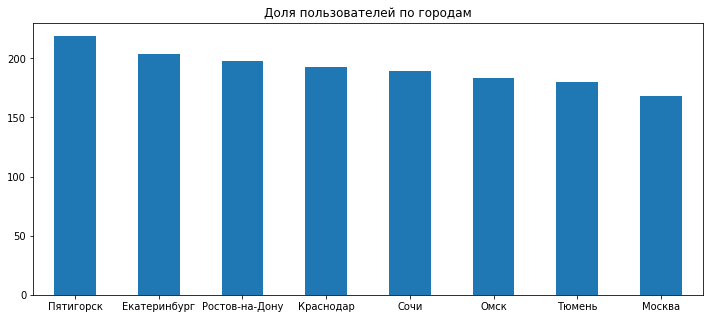

In [6]:
# Строим столбчатую диаграмму распределения пользователей по городам
us_df['city'].value_counts(ascending=False).plot(kind='bar',
                                                 title='Доля пользователей по городам',
                                                 figsize=(12, 5),rot=0);

##### Соотношение пользователей с подпиской и без подписки

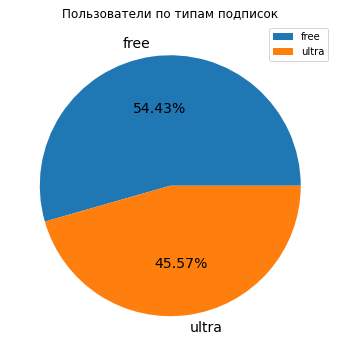

In [7]:
ax = us_df['subscription_type'].value_counts().plot(kind='pie',
                                                    title='Пользователи по типам подписок',
                                                    legend=True,#отобразить легенду
                                                    textprops={'fontsize': 14},#размер подписей
                                                    figsize=(6, 6),
                                                    autopct='%1.2f%%')
ax.yaxis.set_visible(False)


Из полученных данным мы видим, что процент пользователей с подпиской 45.57%. Пользователей же без подписки составляют 54.43% от всех пользователей.

##### Возраст пользователей

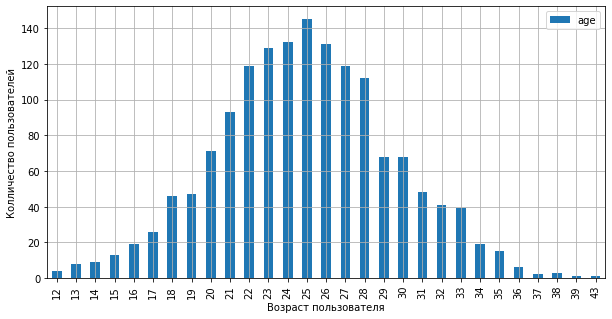

In [8]:
us_df.groupby(['age']).agg({'age':'count'}).plot.bar(y = 'age', grid=True, figsize = (10,5))
plt.xlabel('Возраст пользователя')
plt.ylabel('Колличество пользователей');

Вывод:Распределение пользователей по городам равномерное.Самое наибольшее количество пользователей в Пятигорске.
Бесплатным тарифом пользуется большая часть пользователей(54%)
Основные клиенты сервиса люди от 20 до 30 лет

##### Расстояние, которое пользователь преодолел за одну поездку

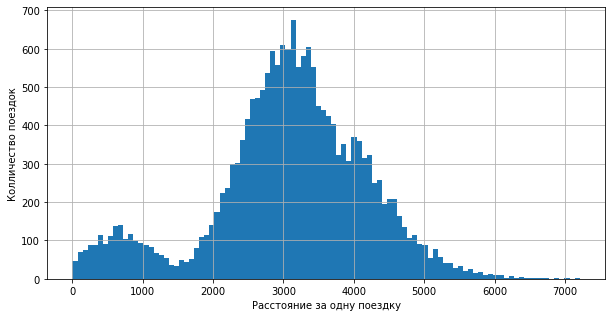

In [9]:
ri_df['distance'].hist(bins=100, grid=True, figsize = (10,5));
plt.xlabel('Расстояние за одну поездку');
plt.ylabel('Колличество поездок');

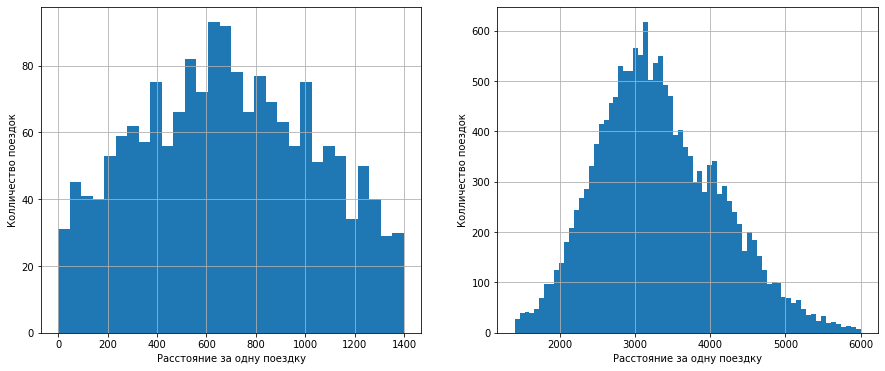

In [10]:
#возвращает фигуру с двумя подграфиком
fig, axes = plt.subplots(1,2,squeeze=False, figsize=(15, 6))
ri_df['distance'].hist(bins=30, grid=True,  ax=axes[0][0],range=(0,1400));
axes[0][0].set_xlabel('Расстояние за одну поездку');
axes[0][0].set_ylabel('Колличество поездок');
ri_df['distance'].hist(bins=70, grid=True, ax=axes[0][1],range=(1400,6000));
axes[0][1].set_xlabel('Расстояние за одну поездку');
axes[0][1].set_ylabel('Колличество поездок');

На графике заметны два пика, один для сверхкоротких поездок 800 м, и второй для поездок в 3000 м.

##### Продолжительность поездок

Text(0, 0.5, 'Колличество поездок')

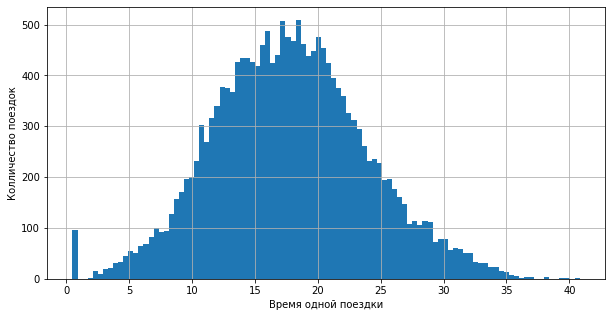

In [11]:
ri_df['duration'].hist(bins=100, grid=True, figsize = (10,5))
plt.xlabel('Время одной поездки')
plt.ylabel('Колличество поездок')

Среднее время пользования самокатом лежит в пределах 15-20 минут.Так же на графике видны поездки длящиеся не более одной минуты, от них нельзя избавляться так как на тарифе без подписки такие поездки могут приносить прибыль из за установленной цены старта. 

На этапе исследовательского анализа было выявлено, что доля поездок пользователей распределена равномерно по восьми городам, больше всего она в Пятигорске, а меньше всего в Москве. Доля пользователей пользующихся подпиской составляет 46%   Основные клиенты сервиса люди от 20 до 30 лет. Пользователи совершают два типа поездок, короткие ~ 800м. и длительные ~3000 м.

#### Шаг 4. Объединение данных
Объединим данные о пользователях, поездках и подписках в один датафрейм. df
##### Создадим ещё два датафрейма

c данными о пользователях без подписки - df_free

с данными о пользователях с подпиской - df_ultra

In [12]:
df=us_df.merge(ri_df, how='outer').merge(su_df,how='outer')
df_free=df.query('subscription_type=="free"')
df_ultra=df.query('subscription_type=="ultra"')
display(df.head())
df.info()

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,2021-01-01,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,2021-01-01,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,2021-04-01,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,2021-08-01,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,2021-08-01,6,0,199


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   date_month         18068 non-null  datetime64[ns]
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(5), object(3)
memory usage: 1.8+ MB


Проверяем датафрейм на типы данных и наличие пропусков 

#####  Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

Text(0, 0.5, 'Колличество поездок')

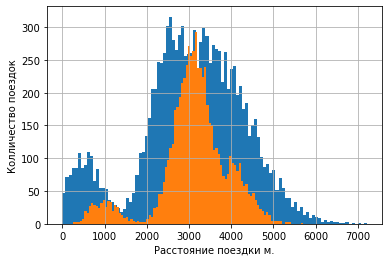

In [13]:
df_free['distance'].hist(bins=100)
df_ultra['distance'].hist(bins=100)
plt.xlabel('Расстояние поездки м.')
plt.ylabel('Колличество поездок')

По графику можно сделать вывод о том что дисперсия расстояния для пользователей с подпиской ниже чем у пользователей без нее 

Text(0, 0.5, 'Колличество поездок')

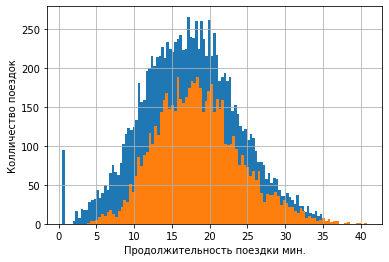

In [14]:
df_free['duration'].hist(bins=100)
df_ultra['duration'].hist(bins=100)
plt.xlabel('Продолжительность поездки мин.')
plt.ylabel('Колличество поездок')

Из графика отмечаем что именно пользователи бесплатной подписки завершают поездку меньше чем за минуту. 
На данном этапе были созданы датафреймы с объединенными данными для всех пользователей, и для пользователей в зависимости от типа их подписки, их мы используем на этапе тестирования.

#### Шаг 5  Подсчёт выручки
Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [15]:
df['duration'] = np.ceil(df['duration'])#округляем время поездки
df_1 = pd.pivot_table(df,
                           index=['user_id','date_month'],
                           values = ['distance', 'duration', 'name', 'subscription_type','subscription_fee','start_ride_price','minute_price'],
                           aggfunc = {'distance': 'sum', 
                                      'duration' : 'sum', 
                                      'name' : 'count', 
                                      'subscription_type' : 'first',
                                     'subscription_fee' : 'first',
                                     'start_ride_price' : 'first',
                                     'minute_price' : 'first'})
df_1.rename(columns = {'name' : 'count'}, inplace = True)
df_1

distance  duration  minute_price  count  \
user_id date_month                                                
1       2021-01-01   7027.511294      42.0             6      2   
        2021-04-01    754.159807       7.0             6      1   
        2021-08-01   6723.470560      46.0             6      2   
        2021-10-01   5809.911100      32.0             6      2   
        2021-11-01   7003.499363      56.0             6      3   
...                          ...       ...           ...    ...   
1534    2021-06-01   3409.468534      26.0             8      2   
        2021-08-01   7622.453034      48.0             8      2   
        2021-09-01   4928.173852      23.0             8      1   
        2021-11-01  13350.015305      78.0             8      4   
        2021-12-01   2371.711192      16.0             8      1   

                    start_ride_price  subscription_fee subscription_type  
user_id date_month                                                        
1       2021-01-01                 0               199             ultra  
        2021-04-01                 0               199             ultra  
        2021-08-01                 0               199             ultra  
        2021-10-01                 0               199             ultra  
        2021-11-01                 0               199             ultra  
...                              ...               ...               ...  
1534    2021-06-01                50                 0              free  
        2021-08-01                50                 0              free  
        2021-09-01                50                 0              free  
        2021-11-01                50                 0              free  
        2021-12-01                50                 0              free  

[11331 rows x 7 columns]

In [16]:
def revenue(row):#функция считает полную стоимость поездки в каждом месяце для каждого пользователя 
    if row['subscription_type'] == 'ultra':
        return row['minute_price'] * row['duration'] + row['subscription_fee']
    elif row['subscription_type'] == 'free':
        return row['minute_price'] * row['duration'] + row['start_ride_price'] * row['count']
    else:
        return 'Not such sub'
df_1['monthly_payment'] = df_1.apply(revenue, axis=1)#добавляем значения выполнения функции в новый столбец
df_1

distance  duration  minute_price  count  \
user_id date_month                                                
1       2021-01-01   7027.511294      42.0             6      2   
        2021-04-01    754.159807       7.0             6      1   
        2021-08-01   6723.470560      46.0             6      2   
        2021-10-01   5809.911100      32.0             6      2   
        2021-11-01   7003.499363      56.0             6      3   
...                          ...       ...           ...    ...   
1534    2021-06-01   3409.468534      26.0             8      2   
        2021-08-01   7622.453034      48.0             8      2   
        2021-09-01   4928.173852      23.0             8      1   
        2021-11-01  13350.015305      78.0             8      4   
        2021-12-01   2371.711192      16.0             8      1   

                    start_ride_price  subscription_fee subscription_type  \
user_id date_month                                                         
1       2021-01-01                 0               199             ultra   
        2021-04-01                 0               199             ultra   
        2021-08-01                 0               199             ultra   
        2021-10-01                 0               199             ultra   
        2021-11-01                 0               199             ultra   
...                              ...               ...               ...   
1534    2021-06-01                50                 0              free   
        2021-08-01                50                 0              free   
        2021-09-01                50                 0              free   
        2021-11-01                50                 0              free   
        2021-12-01                50                 0              free   

                    monthly_payment  
user_id date_month                   
1       2021-01-01            451.0  
        2021-04-01            241.0  
        2021-08-01            475.0  
        2021-10-01            391.0  
        2021-11-01            535.0  
...                             ...  
1534    2021-06-01            308.0  
        2021-08-01            484.0  
        2021-09-01            234.0  
        2021-11-01            824.0  
        2021-12-01            178.0  

[11331 rows x 8 columns]

#### Шаг 6. Проверка гипотез
##### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Проверим правостороннюю гипотезу о равенстве средних двух генеральных совокупностей - пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе.

H0: Время пользователей на подписке ultra = время пользователей на подписке free

H1: Время пользователей на подписке ultra > время пользователей на подписке free

alpha = 0.05


In [17]:
p1=df_ultra['duration'].squeeze() 
p2=df_free['duration'].squeeze() 

In [18]:
results = st.ttest_ind(p1,# Проверка гипотезы
                       p2,
                       equal_var=False, alternative='greater')
print(results.pvalue)# Вычисляем p-value
alpha = 0.05
if results.pvalue < alpha:# Делаем сравнение p-value с параметром допуска и выводим результат сравнения
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')
    
    
display('Среднее для ultra',df_ultra['duration'].mean())
display('Среднее для free',df_free['duration'].mean())


5.6757813771289775e-37
Отвергаем нулевую гипотезу


'Среднее для ultra'

18.54198516280583

'Среднее для free'

17.39090929866399

После проведеного t-тестирования можем отвергнуть нулевую гипотезу, в пользу альтернативной время пользователей на подписке ultra больше времени пользователей на подписке free

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Проверим левостороннюю гипотезу о равенстве среднего генеральной совокупности к числу

H0: Расстояние, которое пользователи с подпиской проезжают за одну поездку меньше или равно 3130 метров

H1: Расстояние, которое пользователи с подпиской проезжают за одну поездку более 3130 метров

In [19]:
interested_value = 3130
results = st.ttest_1samp(df_ultra['distance'],# Проверка гипотезы
                         interested_value,
                         alternative='greater')
print('p-значение:', results.pvalue)# Вычисляем p-value
alpha = 0.05
if results.pvalue < alpha: # Делаем сравнение p-value с параметром допуска и выводим результат сравнения
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')
display('Истинное среднее',df_ultra['distance'].mean())

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


'Истинное среднее'

3115.4453880370247

Не можем отвергнуть нулевую гипотезу о том что пользователи с подпиской проезжают за одну поездку не более 3130 метров

##### Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Проверим правостороннюю гипотезу о равенстве средних двух генеральных совокупностей - пользователи с подпиской платят каждый месяц больше на поездки, чем пользователи на бесплатном тарифе.

H0: Ежемесячная прибыль от пользователей с подпиской = чем от пользователей без подписки.

H1: Ежемесячная прибыль от пользователей с подпиской больше, чем от пользователей без подписки.

In [20]:
# Проверка гипотезы
results = st.ttest_ind(df_1.query('subscription_type == "ultra"')['monthly_payment'], 
                       df_1.query('subscription_type == "free"')['monthly_payment'],
                       equal_var=False,
                       alternative='greater') 

# Вычисляем p-value
print('p-значение:', results.pvalue)

# Делаем сравнение p-value с параметром допуска и выводим результат сравнения
alpha = 0.05
if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')
#print(np.var(df_1.query('subscription_type == "ultra"')['monthly_payment']), np.var(df_1.query('subscription_type == "free"')['monthly_payment']))
display('Среднее для ultra',df_1.query('subscription_type == "ultra"')['monthly_payment'].mean())
display('Среднее для free',df_1.query('subscription_type == "free"')['monthly_payment'].mean())

p-значение: 8.874140893976874e-40
Отвергаем нулевую гипотезу


'Среднее для ultra'

362.7921906022502

'Среднее для free'

328.6413651073845

Не можем отвергнуть нулевую гипотезу.Ежемесячная прибыль от пользователей с подпиской не меньше чем от пользователей без подписки.

#### Вывод
Для работы были использованы три датафрейма сервиса проката самокатов, с пользователями, информацией о поездках, информацией о подписках. из которым выяснили, что колличество пользователей равно 1565, который совершили 18068 поездок.

* Была проведена работа по предварительной обработке данных: 

    * Не было обнаружено пропусков в данных. Поменяли тип данных у столбца date из датафрейма ri_df к типу даты. Также добавили столбец date_month с номером месяца. И удалили 31 дубликат строк из датафрейма с пользователями, что составляет 2% от всех данных

* Проведён анализ данных

    * Частоты встречаимости городов. Из которого выявили, что больше всего пользуются сервисом в г. Пятигорск 14%, меньше всего из 8 городов пользуются в г.Москва - 11 % от общего числа пользователей.

    * Соотношение пользователей с подпиской и без. Пользователей, использующих бесплатную подписку больше - 835 человек, что является ~54% от общего числа пользователей. На платной подписке сидит 699 пользователей, что соответственно является ~46%.

    * Расстояния, которое пользователь преодолел за одну поездку.В среднем расстояние одной поездки составляет 3км. В основном пользователи проезжают от 2.5 км до 4 км. Самые длинные поездки составляют 7 км.
    * Возраста пользователей. Средний возраст пользователей приложения 20-30 лет, это и самый часто встречающийся в данных возраст пользователей. При этом самому юному пользователю 12 лет, а самому возрастному - 43 года.
    * Исследование данных по продолжительности поездок Чаще всего длительность поездки состовляет 13 - 22 минут. Среднее время пользования самокатом лежит в пределах 15-20 минут.Так же на графике видны поездки длящиеся не более одной минуты, от них нельзя избавляться так как на тарифе без подписки такие поездки могут приносить прибыль из за установленной цены старта.

* Были сравнены распределения продолжительности поездок и пройденному пути для пользователей с подпиской и без. У пользователей с подпиской время в пути несколько выше, также, по гистограмме сравнения распределений пройденных дистанций можно заметить, что у пользователей с подпиской меньшая дисперсия в данных. Также, был осуществлён подсчёт ежемесячных затрат пользователей на пользование сервисом.

Были проверены гипотезы:

1. О равенстве средних двух генеральных совокупностей - пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе. После проведеного t-тестирования можем отвергнуть нулевую гипотезу, в пользу альтернативной время пользователей на подписке ultra больше времени пользователей на подписке free

2. О равенстве среднего ген совокупности к числу. Расстояние, которое пользователи с подпиской преодолевают на одну поездку не превышает 3130 м. после проведения t-теста стало понятно, что отвергать данную гипотезу нельзя

3. О равенстве средних двух генеральных совокупностей. Ежемесячная прибыль от пользователей с подпиской равна прибыли от пользователей без подписки по результатам t-тестирования Не можем отвергнуть нулевую гипотезу.Следовательно ежемесячная прибыль от пользователей с подпиской не меньше чем от пользователей без подписки.

По результатам проведенного исследования нельзя утверждать что пользователи подписки ultra приносят больше прибыли так как помесячный средний доход пользователей без подписки значительно выше.

Советы для бизнеса
Масштабирование, с увеличением колличества городов охват будет больше, следовательно и прибыль.

Проводить рекламную компанию для целевой аудитории,20-30 лет,

Увеличить цену сверхкоротких поездок (до 1000 м.) для тарифа free, поскольку имеется пик на графике, с учетом цены старта, поднятие цены замотивирует совершать более длительные поездки,
